In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.formula.api as smf
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
color = sns.color_palette() 
sns.set_style('darkgrid') 
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SalePrice
0,20,RL,nan,7000,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,GdWo,NaN,0,7,2009,WD,136500
1,20,RL,70.000,11767,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,Shed,900,6,2009,WD,120000
2,60,RL,75.000,9675,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2009,WD,253000
3,160,FV,24.000,2160,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2008,WD,170000
4,75,RM,65.000,8850,Pave,NaN,IR1,Bnk,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,7,2006,ConLw,144000


In [3]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType
0,1,30,RM,60.000,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,6,2009,WD
1,2,190,RL,90.000,15750,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,6,2006,WD
2,3,50,RL,65.000,6435,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,10,2006,WD
3,4,60,RL,80.000,10400,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,NaN,0,3,2008,WD
4,5,20,RL,70.000,13300,Pave,NaN,Reg,Lvl,AllPub,...,323,0,0,NaN,NaN,Shed,400,6,2006,WD


In [4]:
# Check for duplicates  (only test set has Id)
idsUnique = len(set(test.Id))
idsTotal = test.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

There are 0 duplicate IDs for 1608 total entries


In [5]:
# Drop Id column
test.drop("Id", axis = 1, inplace = True)

In [6]:
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (804, 79) 
The test data size after dropping Id feature is : (1608, 78) 


# Data Processing

## Outliers

Documentation(not the the one marcel provide) for the Ames Housing Data indicates that there are outliers present in the training data


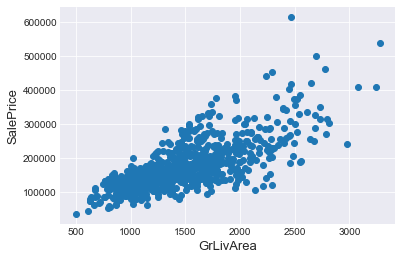

In [7]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

No apparent outliers. 

but There are probably others outliers in the training data. However, removing all them may affect badly our models if ever there were also outliers in the test data. That's why , instead of removing them all, we will just manage to make some of our models robust on them. 

## Target Variable

### SalePrice 

In [8]:
y, lmbda=stats.boxcox(train['SalePrice'])
train['BoxCoxPrice']=((train['SalePrice']**lmbda - 1) / lmbda)
train['LogPrice']=np.log(train['SalePrice'])
prices=['SalePrice','LogPrice','BoxCoxPrice']
print(lmbda)

-0.0773275771249


In [9]:
table1_1=train[prices].describe().round(5)
table1_1.loc['Skew', :]=train[prices].skew() 
table1_1.loc['Kurt', :]=train[prices].kurt() 
table1_1.round(5)

,SalePrice,LogPrice,BoxCoxPrice
count,804.000,804.000,804.000
mean,175324.466,12.004,7.819
std,70035.485,0.371,0.146
min,35000.000,10.463,7.174
25%,129500.000,11.771,7.728
50%,158725.000,11.975,7.809
75%,206225.000,12.237,7.912
max,615000.000,13.329,8.319
Skew,1.581,0.109,-0.007
Kurt,4.277,0.697,0.773


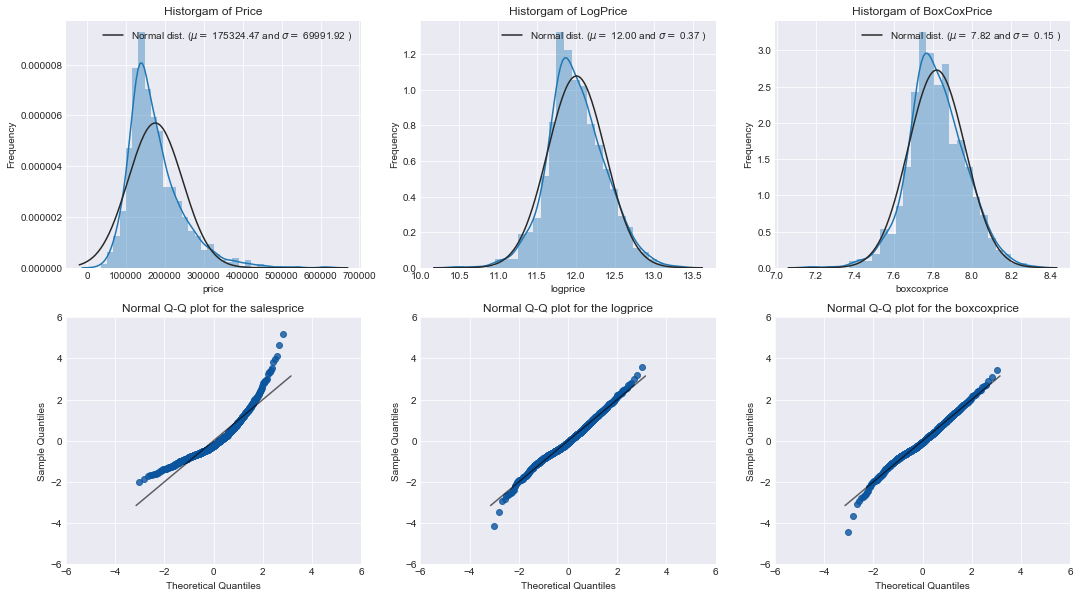

In [10]:
# plot the distribution and the box plot of the responses 
fig, ax= plt.subplots(2,3, figsize=(18,10))
sns.distplot(train['SalePrice'] , fit=norm,ax=ax[0,0]);
(mu, sigma) = norm.fit(train['SalePrice'])
ax[0,0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax[0,0].set(title='Historgam of Price', xlabel='price',ylabel='Frequency')

pp = sm.ProbPlot(train['SalePrice'], fit=True)
qq = pp.qqplot(color=sns.color_palette('Blues')[-1], alpha=0.8, ax=ax[1,0])
a=ax[1,0].get_xlim()[0]
b=ax[1,0].get_xlim()[1]
ax[1,0].plot([a,b],[a,b], color='black', alpha=0.6)
ax[1,0].set_xlim(-6,6)
ax[1,0].set_ylim(-6,6)
ax[1,0].set_title('Normal Q-Q plot for the salesprice')

sns.distplot(train['LogPrice'] , fit=norm,ax=ax[0,1]);
(mu, sigma) = norm.fit(train['LogPrice'])
ax[0,1].set(title='Historgam of LogPrice', xlabel='logprice',ylabel='Frequency')
ax[0,1].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
pp = sm.ProbPlot(train['LogPrice'], fit=True)
qq = pp.qqplot(color=sns.color_palette('Blues')[-1], alpha=0.8, ax=ax[1,1])
a=ax[1,1].get_xlim()[0]
b=ax[1,1].get_xlim()[1]
ax[1,1].plot([a,b],[a,b], color='black', alpha=0.6)
ax[1,1].set_xlim(-6,6)
ax[1,1].set_ylim(-6,6)
ax[1,1].set_title('Normal Q-Q plot for the logprice')

sns.distplot(train['BoxCoxPrice'] , fit=norm,ax=ax[0,2]);
(mu, sigma) = norm.fit(train['BoxCoxPrice'])
ax[0,2].set(title='Historgam of BoxCoxPrice', xlabel='boxcoxprice',ylabel='Frequency')
ax[0,2].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
pp = sm.ProbPlot(train['BoxCoxPrice'], fit=True)
qq = pp.qqplot(color=sns.color_palette('Blues')[-1], alpha=0.8, ax=ax[1,2])
a=ax[1,2].get_xlim()[0]
b=ax[1,2].get_xlim()[1]
ax[1,2].plot([a,b],[a,b], color='black', alpha=0.6)
ax[1,2].set_xlim(-6,6)
ax[1,2].set_ylim(-6,6)
ax[1,2].set_title('Normal Q-Q plot for the boxcoxprice')

plt.show()

right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.

both logprice and boxcoxprice appear more normally distributed. and the standard error of boxcoxprice is smallest. 


## Missing data

In [11]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2412, 80)


In [12]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(23)  # 21 varianles have missing value  
# zoe : logprice and boxcoxprice shown as test set donot contain them. i donot knwo how to remove them .

,Missing Ratio
PoolQC,99.627
MiscFeature,96.020
Alley,93.615
Fence,79.187
LogPrice,66.667
BoxCoxPrice,66.667
FireplaceQu,48.259
LotFrontage,18.698
GarageYrBlt,4.851
GarageQual,4.851


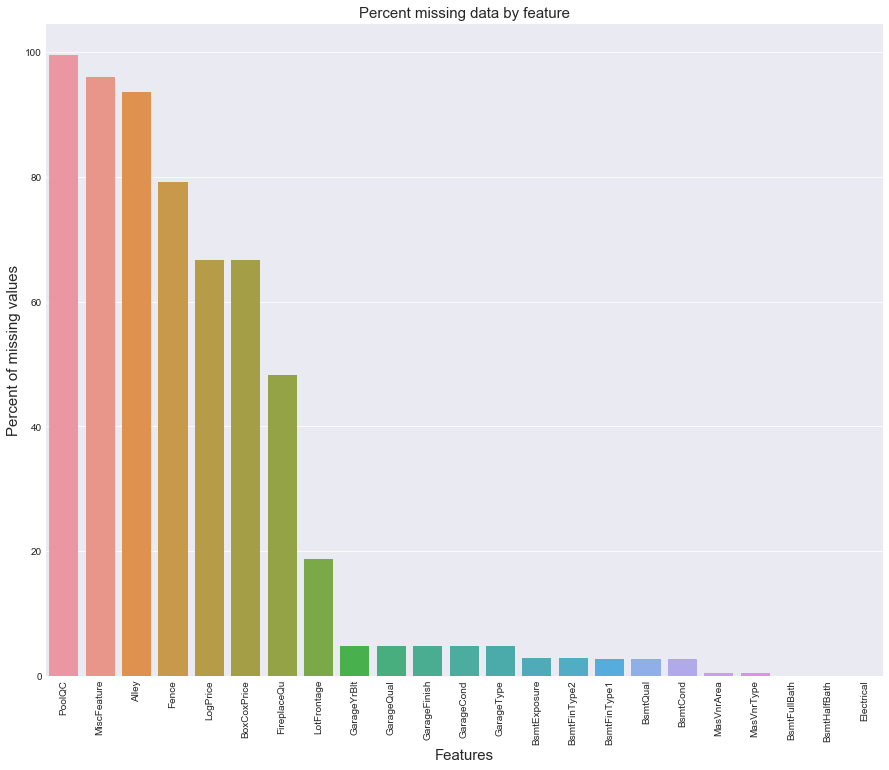

In [13]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [14]:
# Imputing missing values (21)

# Alley : data description says NA means "no alley access"                        
all_data.loc[:, "Alley"] = all_data.loc[:, "Alley"].fillna("None") 
# BsmtQual etc : data description says NA for basement features is "no basement"     
all_data.loc[:, "BsmtQual"] = all_data.loc[:, "BsmtQual"].fillna("No")        
all_data.loc[:, "BsmtCond"] = all_data.loc[:, "BsmtCond"].fillna("No")        
all_data.loc[:, "BsmtExposure"] = all_data.loc[:, "BsmtExposure"].fillna("No")
all_data.loc[:, "BsmtFinType1"] = all_data.loc[:, "BsmtFinType1"].fillna("No")
all_data.loc[:, "BsmtFinType2"] = all_data.loc[:, "BsmtFinType2"].fillna("No")
all_data.loc[:, "BsmtFullBath"] = all_data.loc[:, "BsmtFullBath"].fillna(0)
all_data.loc[:, "BsmtHalfBath"] = all_data.loc[:, "BsmtHalfBath"].fillna(0)
# Fence: data description says NA means "no fence"
all_data.loc[:, "Fence"] = all_data.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
all_data.loc[:, "FireplaceQu"] = all_data.loc[:, "FireplaceQu"].fillna("No")
# GarageType etc : data description says NA for garage features is "no garage"
all_data.loc[:, "GarageType"] = all_data.loc[:, "GarageType"].fillna("No")
all_data.loc[:, "GarageFinish"] = all_data.loc[:, "GarageFinish"].fillna("No")
all_data.loc[:, "GarageQual"] = all_data.loc[:, "GarageQual"].fillna("No")
all_data.loc[:, "GarageCond"] = all_data.loc[:, "GarageCond"].fillna("No")
all_data.loc[:, "GarageYrBlt"] = all_data.loc[:, "GarageYrBlt"].fillna(0)  
# LotFrontage : NA most likely means no lot frontage
all_data.loc[:, "LotFrontage"] = all_data.loc[:, "LotFrontage"].fillna(0)
# MasVnrType : NA most likely means no veneer
all_data.loc[:, "MasVnrType"] = all_data.loc[:, "MasVnrType"].fillna("None")
all_data.loc[:, "MasVnrArea"] = all_data.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
all_data.loc[:, "MiscFeature"] = all_data.loc[:, "MiscFeature"].fillna("No")
# PoolQC : data description says NA means "no pool"
all_data.loc[:, "PoolQC"] = all_data.loc[:, "PoolQC"].fillna("No")
# Electrical: data description says NA means "no Electrical system"  
all_data.loc[:, "Electrical"] =all_data.loc[:, "Electrical"].fillna("No") 

## More features engeneering

### Transforming some numerical variables that are really categorical

In [15]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.   Month Sold (MM)  Year Sold (YYYY)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

### Label Encoding some categorical variables that may contain information in their ordering set

In [16]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2412, 80)


### Adding one more important feature
Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [17]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

### Skewed features

In [18]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,20.670
PoolArea,19.222
LotArea,13.400
LowQualFinSF,13.238
3SsnPorch,11.942
LandSlope,4.896
KitchenAbvGr,4.678
EnclosedPorch,4.093
ScreenPorch,3.998
BsmtFinSF2,3.921


In [19]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])
#train

There are 61 skewed numerical features to Box Cox transform


In [20]:
### the two report has different method. one transfer to boxcox, another one use logs. Temporily i choose boxcox. 
## the log transform also copy above. maybe we can test both of them.  

### Getting dummy categorical features

In [21]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2412, 223)


In [22]:
train_new = all_data[:ntrain]
test_new = all_data[ntrain:]
train_new.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BoxCoxPrice,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_VWD,SaleType_WD,Utilities_AllPub,Utilities_NoSewr
0,11.718,0.000,0.000,0.730,1.541,2.563,2.056,1.541,10.935,0.000,...,0,0,0,0,0,0,0,1,1,0
1,13.029,0.000,0.000,0.730,1.541,2.555,2.056,1.194,12.338,0.000,...,0,0,0,0,0,0,0,1,1,0
2,12.429,11.699,0.000,0.730,1.541,2.601,2.056,1.194,9.329,0.000,...,0,0,0,0,0,0,0,1,1,0
3,11.086,11.223,0.000,1.194,1.541,2.577,2.056,1.541,10.741,0.000,...,0,0,0,0,0,0,0,1,1,0
4,11.558,11.753,0.000,0.730,1.541,2.567,2.056,1.541,0.000,0.000,...,0,0,0,0,1,0,0,0,1,0


### Deleting  

In [23]:
# we should use old train set to draw some plot below( such as corr matrix), but all dealing will be in train_new

In [24]:
### Interesting to note that PoolQC only have 3 data points that are off a different value
df = pd.DataFrame({'PoolQC':list(train['PoolQC'])})
pd.get_dummies(df).head()

,PoolQC_Ex,PoolQC_Gd,PoolQC_TA
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [25]:
del train_new['PoolQC']
del train_new['PoolArea']
del test_new['PoolQC']
del test_new['PoolArea']

In [26]:
df = pd.DataFrame({'Fence':list(train['Fence'])})
pd.get_dummies(df).head()
#Here, the base case Fence means the house does not have a 

,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw
0,0,1,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


In [27]:
del train['MiscFeature']
del test['MiscFeature']

## Predictors

In [28]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]
## zoe: this use old train set.

Numerical features : 38
Categorical features : 41


In [29]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 197
Remaining NAs for numerical features in train : 0


### Continuous Variables

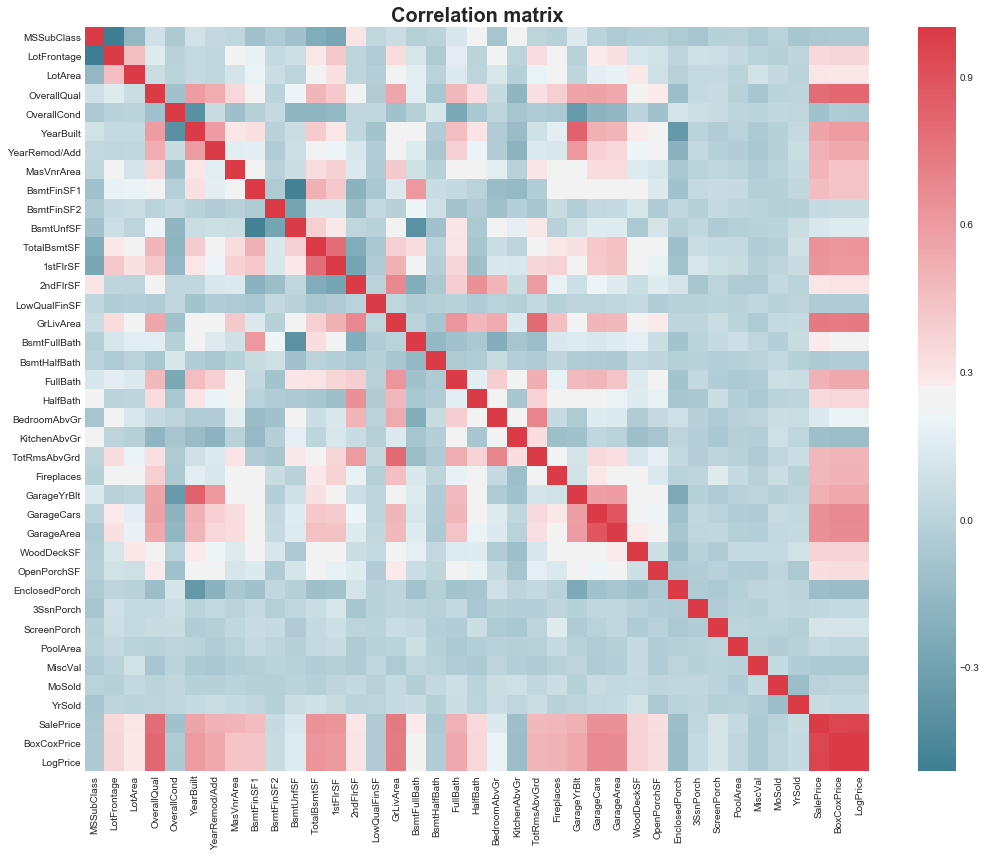

In [30]:
train.corr().round(2)
fig, ax = plt.subplots(figsize=(15,12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(train.corr(), ax=ax, cmap=cmap)
ax.set_title('Correlation matrix', fontweight='bold', fontsize=20)
plt.tight_layout()
plt.show()
## zoe: using old train set as well.

In [31]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)
## zoe: old train set.

Find most important features relative to target
SalePrice        1.000
LogPrice         0.958
BoxCoxPrice      0.952
OverallQual      0.790
GrLivArea        0.738
GarageArea       0.645
GarageCars       0.643
TotalBsmtSF      0.635
1stFlrSF         0.629
YearBuilt        0.561
GarageYrBlt      0.515
FullBath         0.509
YearRemod/Add    0.505
MasVnrArea       0.495
Fireplaces       0.485
TotRmsAbvGrd     0.479
BsmtFinSF1       0.464
WoodDeckSF       0.373
LotFrontage      0.345
HalfBath         0.341
OpenPorchSF      0.329
LotArea          0.293
2ndFlrSF         0.292
BsmtFullBath     0.277
BedroomAbvGr     0.142
BsmtUnfSF        0.123
ScreenPorch      0.105
YrSold           0.058
BsmtFinSF2       0.046
PoolArea         0.038
3SsnPorch        0.028
MoSold          -0.000
LowQualFinSF    -0.044
MiscVal         -0.053
BsmtHalfBath    -0.056
MSSubClass      -0.060
OverallCond     -0.104
KitchenAbvGr    -0.114
EnclosedPorch   -0.128
Name: SalePrice, dtype: float64


In [32]:
correlation=train.corr()
print(len(correlation['SalePrice'])) #no object included  

high_corr=[]
print('corr >=0.3 :')
for i in numerical_features:
    if correlation['SalePrice'][i]>=0.3:
        high_corr.append(i) 
print(high_corr)
print("------------------------")
print("corr<=0.3 :")
for i in numerical_features:
    if correlation['SalePrice'][i]<=-0.3:
        print(i)
    else: 
        print('no predictor')
        break

39
corr >=0.3 :
['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemod/Add', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'BoxCoxPrice', 'LogPrice']
------------------------
corr<=0.3 :
no predictor


### OverallQual

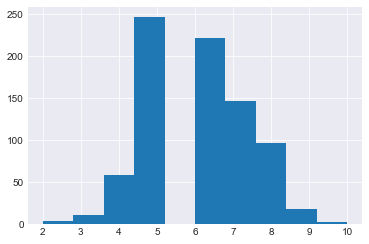

In [33]:
# corr is close to 0.8
# this is Ordinal 
# why loss at meddle?

plt.hist(train['OverallQual'])
plt.show() 

In [34]:
count_o=train.groupby("OverallQual").count()
print(count_o.loc[:,'SalePrice'])  # drop ?

OverallQual
2       4
3      11
4      58
5     246
6     221
7     147
8      96
9      18
10      3
Name: SalePrice, dtype: int64


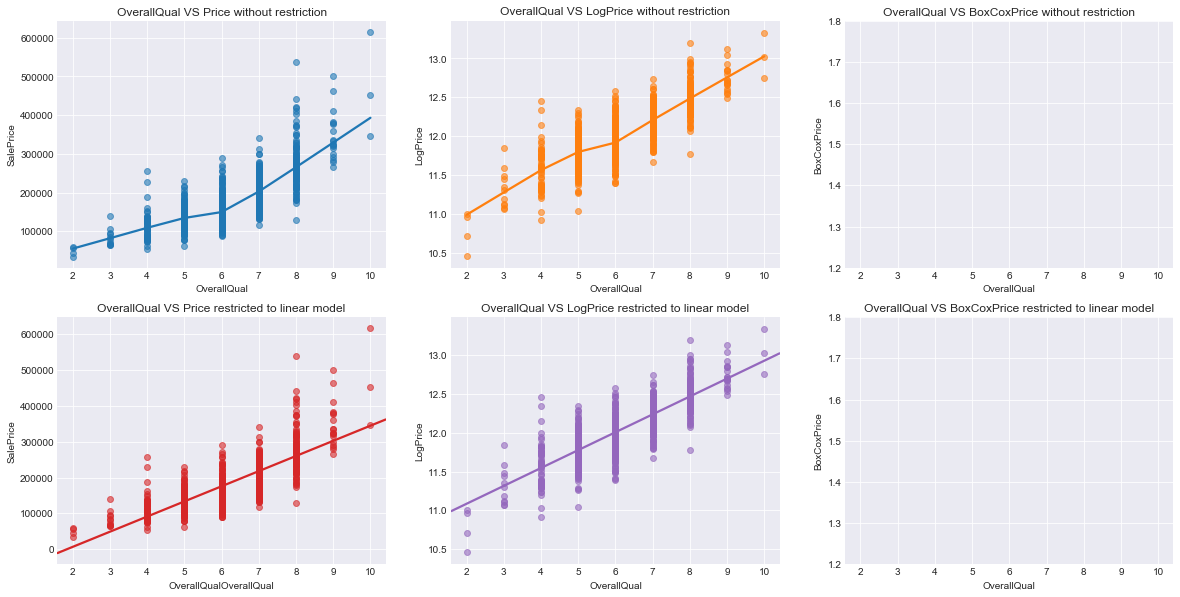

In [35]:
# EDA for OverallQual
## maybe just add one knot

fig, ax= plt.subplots(2,3, figsize=(20,10))

sns.regplot(train['OverallQual'], train['SalePrice'], ax=ax[0,0],ci=True, lowess=True, scatter_kws={'alpha':0.6})
ax[0,0].set(title='OverallQual VS Price without restriction',xlabel='OverallQual')

sns.regplot(train['OverallQual'], train['LogPrice'], ax=ax[0,1],ci=True, lowess=True,scatter_kws={'alpha':0.6})
ax[0,1].set(title='OverallQual VS LogPrice without restriction',xlabel='OverallQual')

sns.regplot(train['OverallQual'], train['BoxCoxPrice'], ax=ax[0,2], ci=True,lowess=True,scatter_kws={'alpha':0.6})
ax[0,2].set(title='OverallQual VS BoxCoxPrice without restriction',xlabel='OverallQual')
ax[0,2].set_ylim(1.2,1.8)

sns.regplot(train['OverallQual'], train['SalePrice'], ax=ax[1,0],ci=True, scatter_kws={'alpha':0.6})
ax[1,0].set(title='OverallQual VS Price restricted to linear model',xlabel='OverallQualOverallQual')

sns.regplot(train['OverallQual'], train['LogPrice'], ax=ax[1,1],ci=True, scatter_kws={'alpha':0.6})
ax[1,1].set(title='OverallQual VS LogPrice restricted to linear model',xlabel='OverallQual')

sns.regplot(train['OverallQual'], train['BoxCoxPrice'], ax=ax[1,2], ci=True,scatter_kws={'alpha':0.6})
ax[1,2].set(title='OverallQual VS BoxCoxPrice restricted to linear model',xlabel='OverallQual')
ax[1,2].set_ylim(1.2,1.8)

plt.show()

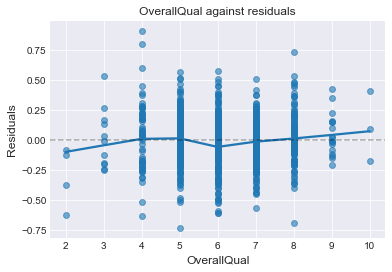

In [36]:
# EDA for the nonlinear approximation of OverallQuat 

# a nonparametric (model free) estimate of the relationship between the lot and the residuals

formula1_1='LogPrice ~ OverallQual'
reg1_1 = smf.ols(formula=formula1_1, data=train).fit()
residuals1_1=reg1_1.resid

fig, ax= plt.subplots()
sns.regplot(train['OverallQual'], residuals1_1, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6})
ax.set_xlabel('OverallQual',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('OverallQual against residuals')
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

In [37]:
# nonlinearity formulation for lot with 1 knot

xi1_1=train['OverallQual'].median()
train['Step1_1']=(train['OverallQual']>xi1_1)*(train['OverallQual']-xi1_1)

formula1_2='LogPrice ~ OverallQual + Step1_1'
reg1_2 = smf.ols(formula=formula1_2, data=train).fit()
print(reg1_2.summary())

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     794.9
Date:                Sun, 27 Aug 2017   Prob (F-statistic):          6.27e-191
Time:                        17:51:13   Log-Likelihood:                 97.220
No. Observations:                 804   AIC:                            -188.4
Df Residuals:                     801   BIC:                            -174.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      10.7271      0.061    174.854      

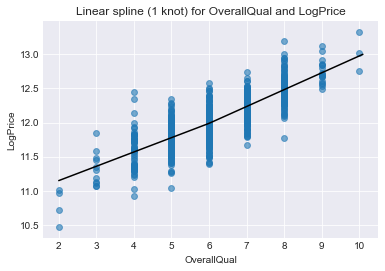

In [38]:
# plot 1 for the reg1_2

fig, ax= plt.subplots()
sns.regplot(train['OverallQual'], train['LogPrice'], ci=None, fit_reg=False, scatter_kws={'s': 35, 'alpha': 0.6})

a=train['OverallQual'].min()
b=train['OverallQual'].max()+0.1
x=np.linspace(a, b)

y=reg1_2.predict({'OverallQual': x, 'Step1_1': (x-xi1_1)*((x>xi1_1).astype(int))})
ax.plot(x, y, color='Black')

ax.set_xlabel('OverallQual')
ax.set_ylabel('LogPrice')
ax.set_title('Linear spline (1 knot) for OverallQual and LogPrice')

sns.despine()
plt.show()

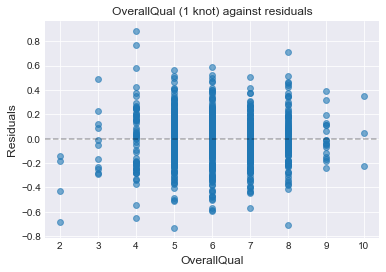

In [39]:
formula1_2='LogPrice ~ OverallQual + Step1_1'
reg1_2 = smf.ols(formula=formula1_2, data=train).fit()
residuals1_2=reg1_2.resid

fig, ax= plt.subplots()
sns.regplot(train['OverallQual'], residuals1_2, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6})
ax.set_xlabel('OverallQual',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('OverallQual (1 knot) against residuals')
plt.axhline(color='Black', alpha=0.3, linestyle='--')  
plt.show()

### Categorial variables

In [40]:
## zoe: the plot belowi cannot be run by train_new

In [41]:
print(train['MSSubClass'].unique())

count1=train.groupby("MSSubClass").count()
print(count1.loc[:,'SalePrice']) 

[ 20  60 160  75  50  30  90 180 190 120  70  80  85  40  45 150]
MSSubClass
20     295
30      40
40       2
45       4
50      84
60     149
70      37
75       6
80      31
85      18
90      31
120     47
150      1
160     40
180      7
190     12
Name: SalePrice, dtype: int64


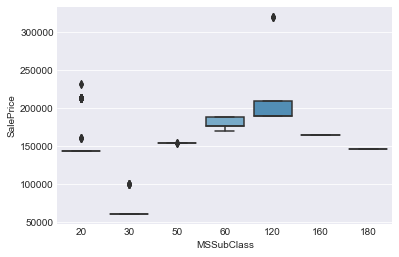

In [42]:
rows=train['MSSubClass'] # too few observations for 150， 40，45 
sns.boxplot(x=train.loc[rows,'MSSubClass'], y=train.loc[rows,'SalePrice'], palette='Blues')
plt.show()
# nonlinear relationship, so itis better to treat it as categorial variable.
# apparent outliers.... 

In [43]:
print(train['OverallQual'].unique())

count1=train.groupby("OverallQual").count()
print(count1.loc[:,'SalePrice'])

[ 5  7  6  8  4  9  3  2 10]
OverallQual
2       4
3      11
4      58
5     246
6     221
7     147
8      96
9      18
10      3
Name: SalePrice, dtype: int64


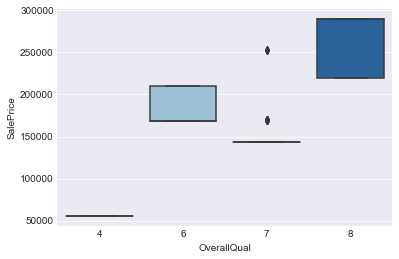

In [44]:
rows=train['OverallQual'] # this plot has problem , donot show all classes
sns.boxplot(x=train.loc[rows,'OverallQual'], y=train.loc[rows,'SalePrice'], palette='Blues')
plt.show()

In [45]:
print(train['OverallCond'].unique())

count1=train.groupby("OverallCond").count()
print(count1.loc[:,'SalePrice'])

[8 5 6 7 4 3 9]
OverallCond
3     15
4     27
5    420
6    172
7    113
8     49
9      8
Name: SalePrice, dtype: int64


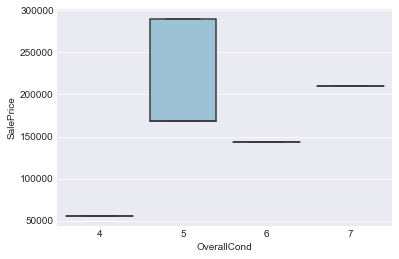

In [46]:
rows=train['OverallCond'] # this plot has problem as well
sns.boxplot(x=train.loc[rows,'OverallCond'], y=train.loc[rows,'SalePrice'], palette='Blues')
plt.show()

In [47]:
count2=train.groupby("MSZoning").count()
print(count2.loc[:,'SalePrice'])

MSZoning
C (all)      3
FV          39
I (all)      1
RH           9
RL         628
RM         124
Name: SalePrice, dtype: int64


In [48]:
## zoe: the cell below ,,, i think should check plot first. so , i haven't run them. 